<a href="https://colab.research.google.com/github/greymouse1/spatialanalysis/blob/main/continuity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code is licenced under MIT licence
Author: Nikola Grlj
Credits:

Tutorial from Momepy package website at http://docs.momepy.org/en/stable/user_guide/graph/coins.html
based on paper by Tripathy et al. (2020)

OpenAI. (2024). ChatGPT (version 4) [Large language model]. OpenAI. https://openai.com/chatgpt



Tripathy, P., Rao, P., Balakrishnan, K., & Malladi, T. (2020). An open-source tool to extract natural continuity and hierarchy of urban street networks. Environment and Planning B: Urban Analytics and City Science. http://dx.doi.org/10.1177/2399808320967680

In [ ]:
!pip install osmnx
!pip install momepy
!pip install mapclassify>=2.4.0 # install mapclassify with version >=2.4.0
import osmnx as ox
import geopandas as gpd
import momepy

In [ ]:
# Load shp file with city polygon boundary (WGS84)

bandung_pol = gpd.read_file("/content/bandung_pol/bandung_pol.shp").geometry.iloc[0]

In [31]:
# Retrieve the graph within the polygon's boundaries
# This will pull OSM data from inside the polygon and create a networkX graph

graph = ox.graph_from_polygon(
    bandung_pol,
    network_type='drive',  # Choose network type (e.g., 'drive', 'walk', 'bike', etc.)
    simplify=True,         # Simplify graph (remove unnecessary nodes)
    retain_all=False,      # Keep only the largest connected component
    truncate_by_edge=False  # Truncate by edge to keep nodes near the edge
)


In [32]:
# Reproject graph
# Choice of final projection is automatic, original must be WGS84

bandung_streets = ox.projection.project_graph(graph)

In [37]:
# Create gdf from graph so it can be used later on

bandung_gdf = ox.graph_to_gdfs(
    ox.convert.to_undirected(bandung_streets),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
)

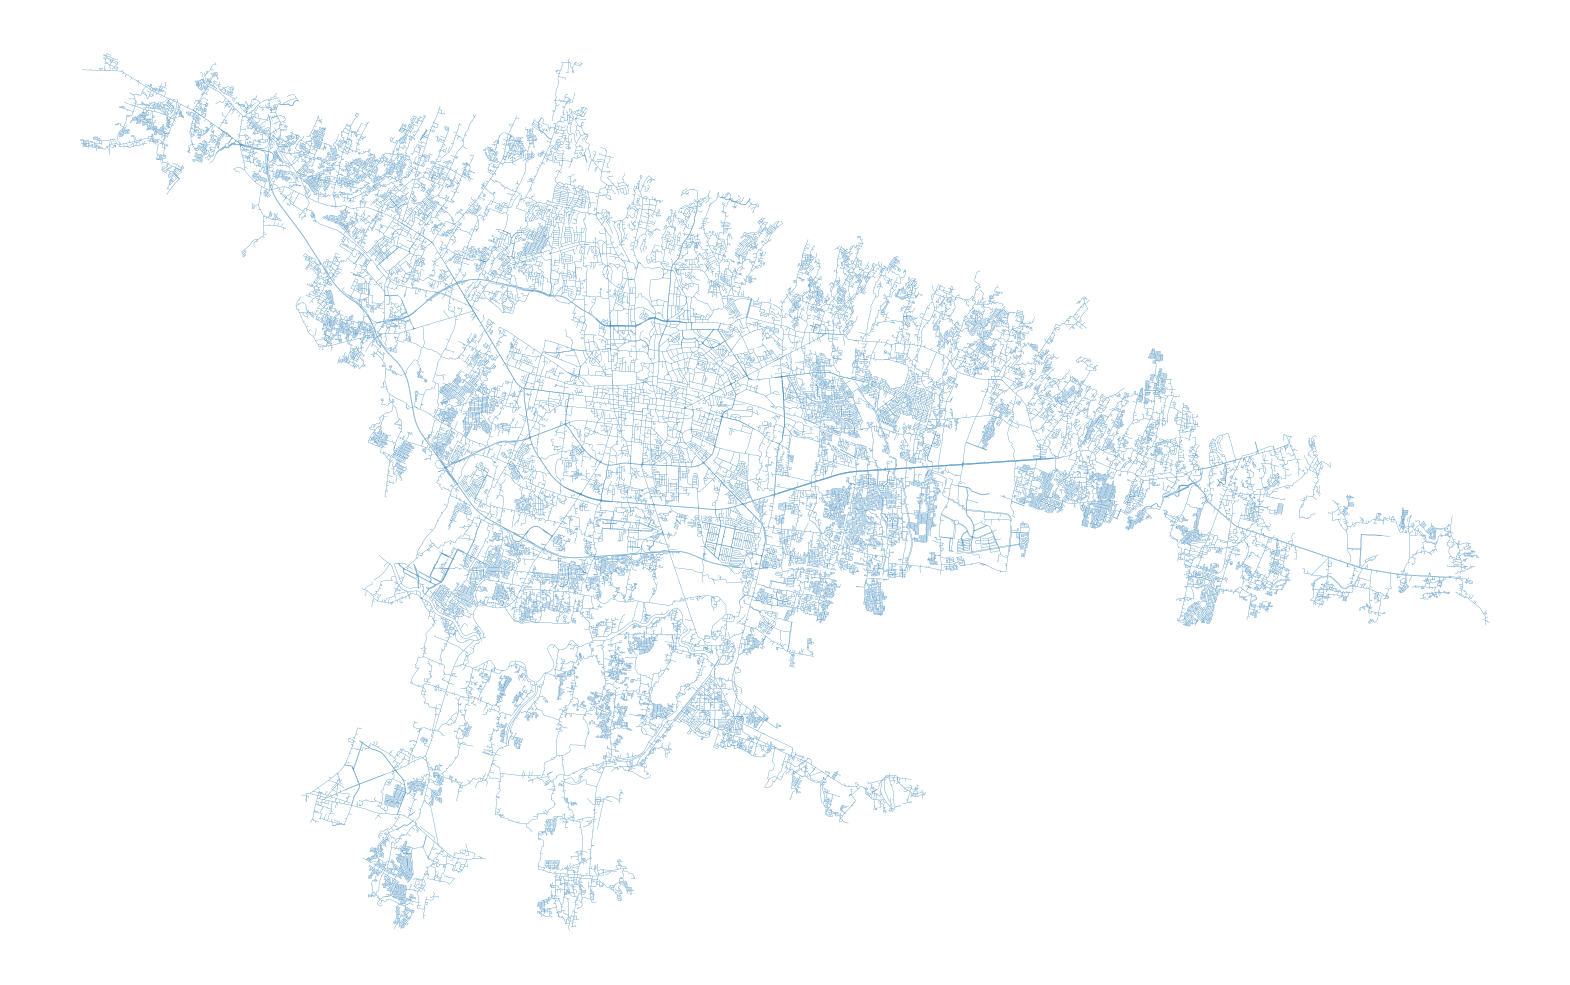

In [38]:
# Plot downloaded OSM roads

bandung_gdf.plot(figsize=(20, 20), linewidth=0.2).set_axis_off()

In [39]:
# Calculate continuity from the gdf

continuity = momepy.COINS(bandung_gdf)

In [41]:
# Pull out stroke

bandung_stroke_gdf = continuity.stroke_gdf()

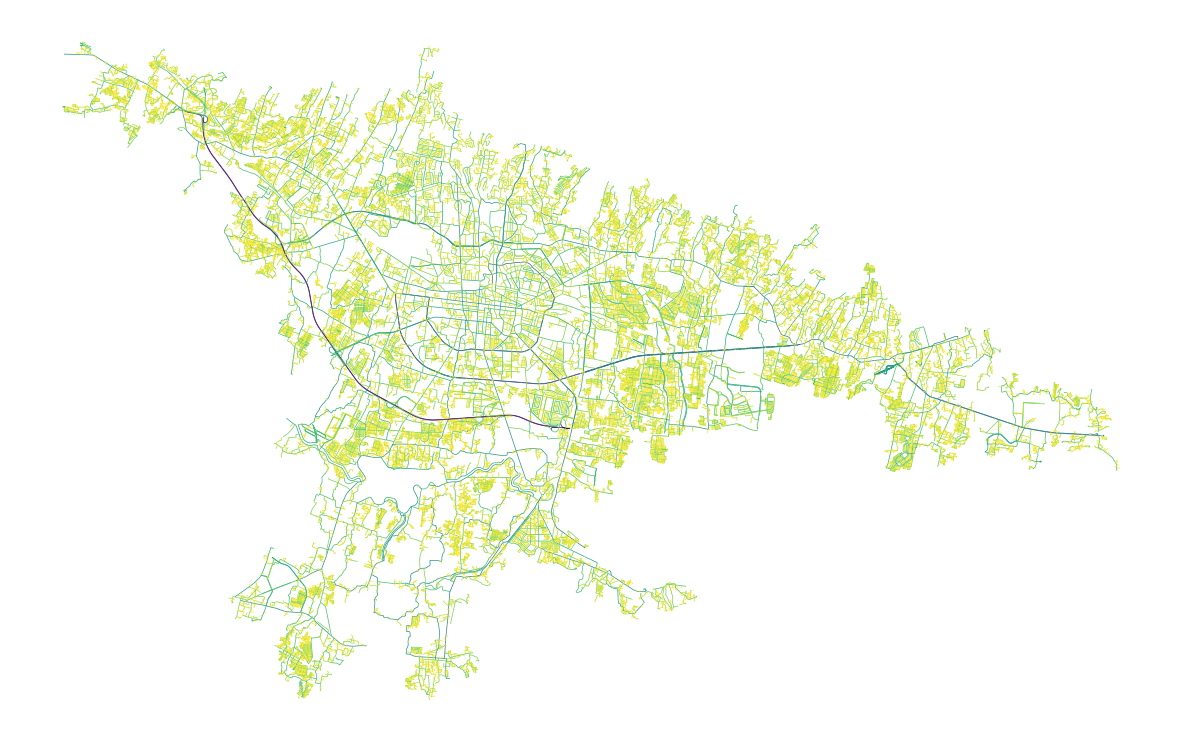

In [44]:
# Plot stroke

bandung_stroke_gdf.plot(
    bandung_stroke_gdf.length,
    figsize=(15, 15),
    cmap="viridis_r",
    linewidth=0.5,
    scheme="headtailbreaks",
).set_axis_off()